In [1]:
import os
import json
import torch
import numpy as np
from matplotlib import pyplot as plt
from models import TransformerEncoder
import matplotlib.gridspec as gridspec
from torch.utils.data import DataLoader
from matplotlib.ticker import MultipleLocator 
from datasets import MVTSDataset, find_padding_masks
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Inputation Plots**

In [2]:
# Read in train and validation indices
with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
train_indices = data_indices['train_indices']
val_indices = data_indices['val_indices']

In [3]:
# Create loaders
train_dataloader = DataLoader(MVTSDataset(train_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=10, shuffle=True, drop_last=True)
val_dataloader = DataLoader(MVTSDataset(val_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=10, shuffle=True, drop_last=True)

In [12]:
# Load best trained model

model = TransformerEncoder(feat_dim=35,
                                    max_len=40,
                                    d_model=64, 
                                    n_heads=8, 
                                    num_layers=1,
                                    dim_feedforward=256, 
                                    freeze=True)
model.float();
model.load_state_dict(torch.load('../temp/inputting_unity_norm.pt'));
model.eval();

In [15]:
x, mask, _ = next(iter(val_dataloader))
padding_mask = find_padding_masks(x) 
x = torch.nan_to_num(x)
x_masked = x * mask 
target_masks = ~mask  
x = x.to(device)
x_masked = x_masked.to(device)
target_masks = target_masks.to(device)
padding_mask = padding_mask.to(device)
y_hat, _ = model(x_masked, padding_mask)

/var/folders/f9/n3qmt52j5rzc2pm_q_cmx6_80000gn/T/ipykernel_21829/2530006218.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0:2, 0])


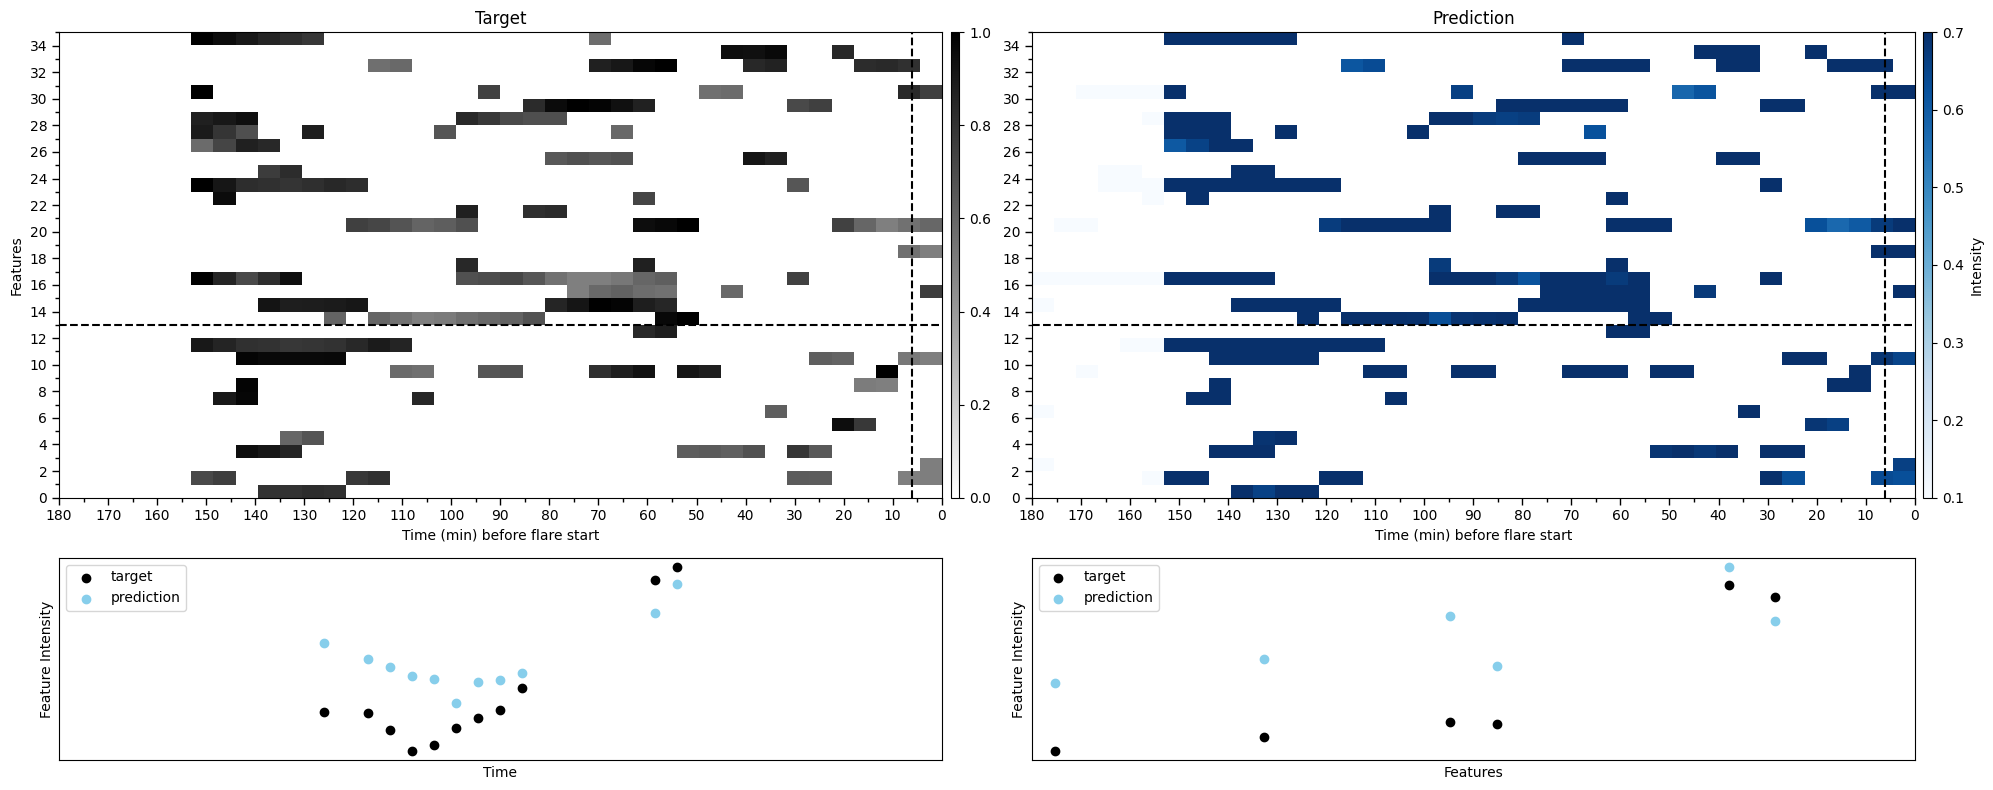

In [16]:
select_instance = 5
select_feature = 13
vertical_select = 38
prediction_array = np.squeeze(y_hat)
target_array = np.squeeze(x)
mask_array = np.squeeze(x_masked)

prediction_array = y_hat[select_instance, :, :].T.detach().numpy()
target_array = x[select_instance, :, :].T.detach().numpy()
mask_array = target_masks[select_instance, :, :].T.detach().numpy()

target_array[~mask_array] = np.nan
prediction_array[~mask_array] = np.nan
prediction_vec = prediction_array[select_feature, :]
target_vec = target_array[select_feature, :]
mask_vec = mask_array[select_feature, :]

prediction_vec_fet = prediction_array[:, vertical_select]
target_vec_fet = target_array[:, vertical_select]
mask_vec_fet = mask_array[:, vertical_select]

fig = plt.subplots(figsize=(20, 8))
gs = gridspec.GridSpec(3, 2)

ax1 = plt.subplot(gs[0:2, 0])
ax1.set_title('Target')
ax1.set_ylabel('Features')
ax1.set_xlabel('Time (min) before flare start')
im1=ax1.imshow(target_array, aspect='auto', cmap='binary', label='target', extent=[180, 0, 35, 0])
ax1.axvline(x=6, color='k', linestyle='--')
ax1.axhline(y=select_feature, color='k', linestyle='--')
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.tick_params(which='major', length=5,width=1)
ax1.tick_params(which='minor', length=3,width=1)
ax1.set_ylim(0,35)
cbar = plt.colorbar(im1, cax=ax1.inset_axes([1.01, 0, 0.01, 1]), aspect=10)

ax2 = plt.subplot(gs[0:2, 1])
ax2.set_title('Prediction')
ax2.set_xlabel('Time (min) before flare start')
im2 = ax2.imshow(prediction_array, aspect='auto', cmap='Blues', label='prediction', vmin=0.1, vmax=.7, extent=[180, 0, 35, 0])
ax2.axvline(x=6, color='k', linestyle='--')
ax2.axhline(y=select_feature, color='k', linestyle='--')
ax2.xaxis.set_major_locator(MultipleLocator(10))
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.tick_params(which='major', length=5,width=1)
ax2.tick_params(which='minor', length=3,width=1)
ax2.set_ylim(0,35)
cbar = plt.colorbar(im2, cax=ax2.inset_axes([1.01, 0, 0.01, 1]), aspect=10)
cbar.set_label('Intensity')

ax3 = plt.subplot(gs[2, 0])
ax3.set_xlabel('Time')
ax3.set_ylabel('Feature Intensity')
ax3.scatter(range(len(target_vec)), target_vec, c='k', label='target')
ax3.scatter(range(len(prediction_vec)), prediction_vec, c='skyblue', label='prediction')
ax3.set_xlim(0,40)
ax3.legend(loc='upper left')
ax3.set_yticks([])
ax3.set_xticks([])

ax4 = plt.subplot(gs[2, 1])
ax4.set_xlabel('Features')
ax4.set_ylabel('Feature Intensity')
ax4.scatter(range(len(target_vec_fet)), target_vec_fet, c='k', label='target')
ax4.scatter(range(len(prediction_vec_fet)),prediction_vec_fet, c='skyblue', label='prediction') 
ax4.set_xlim(0,38)
ax4.legend(loc='upper left')
ax4.set_yticks([])
ax4.set_xticks([])
ax4.set_xlim(0,38)

plt.tight_layout()
# plt.savefig(f'../experiments/pretrained_unity_simple/figs/autoregressive_denoising_unity_simple_{ref}.png', dpi=300, bbox_inches='tight')
plt.show()

In [74]:
# Create a custome color map 

# import my colors 
import pickle 
with open('/Users/brandonlpanos/my_colors.pkl', 'rb') as f:
    my_colors = pickle.load(f)

# drop light_cream from the dictionary
my_colors.pop('light_cream')
my_colors

{'light_blue': '#F0F6F7',
 'dark_blue': '#E4EFF1',
 'light_brown': '#EDE4DD',
 'dark_brown': '#E0D0C4',
 'burn_brick': '#E5C5B2',
 'dark_brick': '#B86029'}

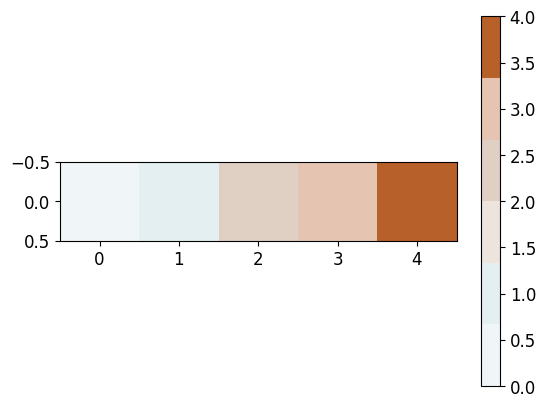

In [75]:
# create custome color map (discrete)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl

# Define the hex color values
hex_colors = [color for name, color in my_colors.items() ]

# Create the ListedColormap
custom_cmap = ListedColormap(hex_colors)

# Example usage: plot a colorbar with the custom colormap
plt.colorbar(plt.imshow([[0, 1, 2, 3, 4]], cmap=custom_cmap))
plt.show()


/var/folders/f9/n3qmt52j5rzc2pm_q_cmx6_80000gn/T/ipykernel_56155/1941081165.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0:2, 0])


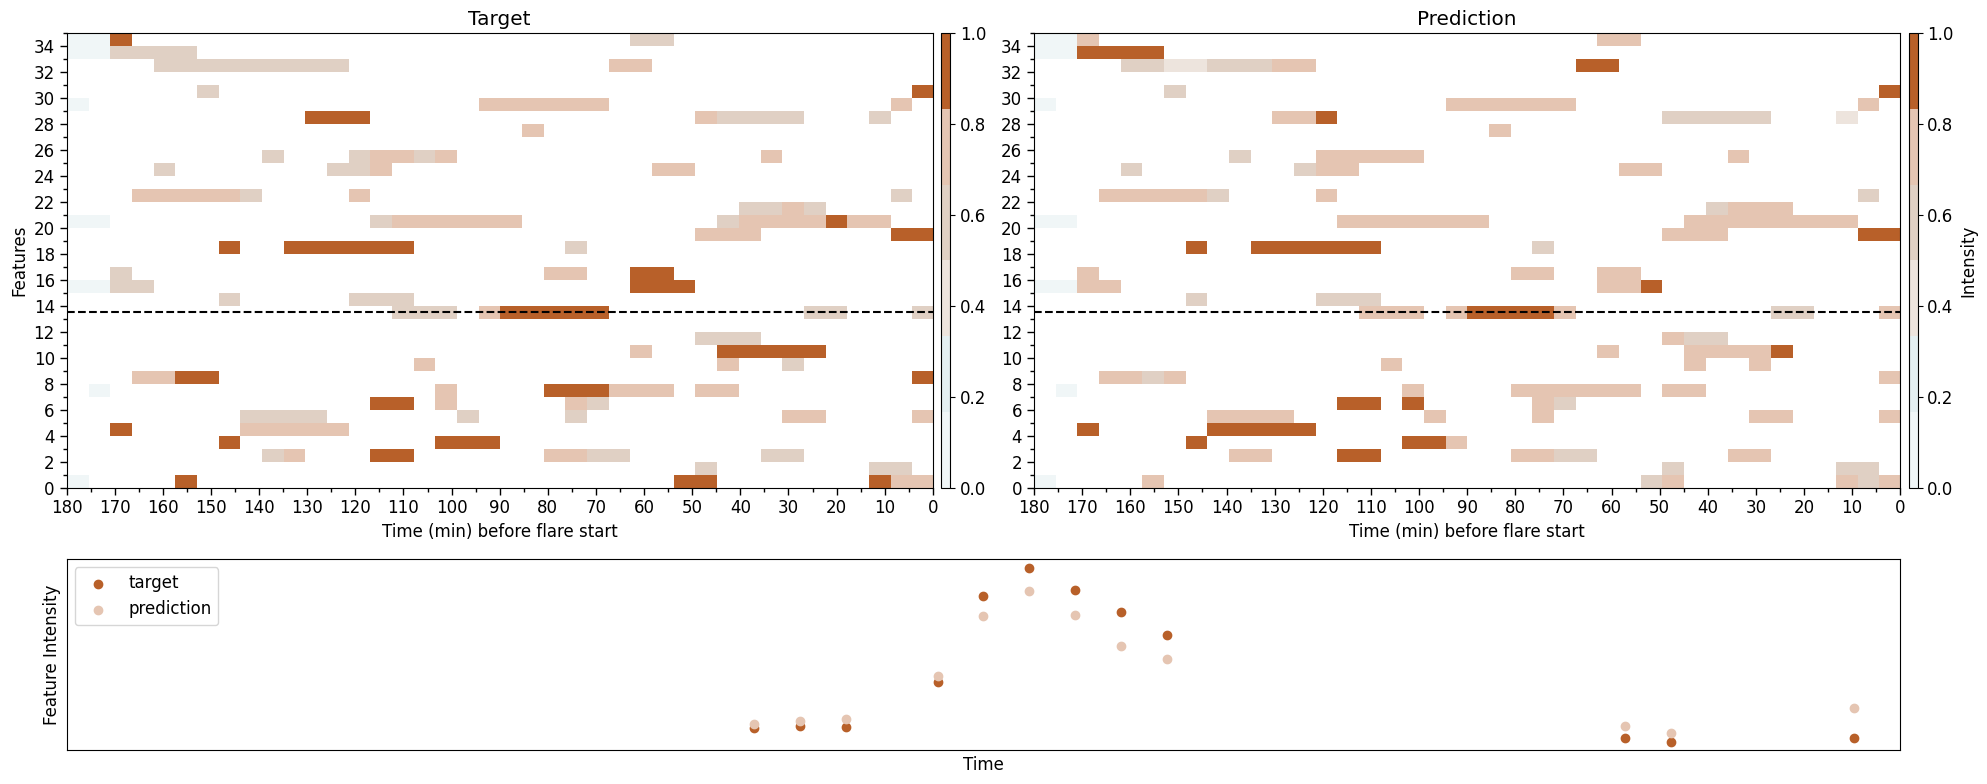

In [76]:
# select_instance = 5
# select_feature = 13
# vertical_select = 38

# prediction_array = torch.squeeze(y_hat)
# target_array = torch.squeeze(x)
# mask_array = torch.squeeze(x_masked)

# prediction_array = y_hat[select_instance, :, :].T.detach().numpy()
# target_array = x[select_instance, :, :].T.detach().numpy()
# mask_array = target_masks[select_instance, :, :].T.detach().numpy()

# target_array[~mask_array] = np.nan
# prediction_array[~mask_array] = np.nan
# prediction_vec = prediction_array[select_feature, :]
# target_vec = target_array[select_feature, :]
# mask_vec = mask_array[select_feature, :]

# prediction_vec_fet = prediction_array[:, vertical_select]
# target_vec_fet = target_array[:, vertical_select]
# mask_vec_fet = mask_array[:, vertical_select]

fig = plt.subplots(figsize=(20, 8))
gs = gridspec.GridSpec(3, 2)

ax1 = plt.subplot(gs[0:2, 0])
ax1.set_title('Target')
ax1.set_ylabel('Features')
ax1.set_xlabel('Time (min) before flare start')
im1=ax1.imshow(target_array, aspect='auto', cmap=custom_cmap, label='target', extent=[180, 0, 35, 0], vmin=0., vmax=1)
ax1.axhline(y=select_feature+0.5, color='k', linestyle='--')
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.tick_params(which='major', length=5,width=1)
ax1.tick_params(which='minor', length=3,width=1)
ax1.set_ylim(0,35)
cbar = plt.colorbar(im1, cax=ax1.inset_axes([1.01, 0, 0.01, 1]), aspect=10)

ax2 = plt.subplot(gs[0:2, 1])
ax2.set_title('Prediction')
ax2.set_xlabel('Time (min) before flare start')
im2 = ax2.imshow(prediction_array, aspect='auto', cmap=custom_cmap, label='prediction', vmin=0., vmax=1, extent=[180, 0, 35, 0])
ax2.axhline(y=select_feature + 0.5, color='k', linestyle='--')
ax2.xaxis.set_major_locator(MultipleLocator(10))
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_major_locator(MultipleLocator(2))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.tick_params(which='major', length=5,width=1)
ax2.tick_params(which='minor', length=3,width=1)
ax2.set_ylim(0,35)
cbar = plt.colorbar(im2, cax=ax2.inset_axes([1.01, 0, 0.01, 1]), aspect=10)
cbar.set_label('Intensity')

ax3 = plt.subplot(gs[2, :])
ax3.set_xlabel('Time')
ax3.set_ylabel('Feature Intensity')
ax3.scatter(range(len(target_vec)), target_vec, c='#B86029', label='target')
ax3.scatter(range(len(prediction_vec)), prediction_vec, c='#E5C5B2', label='prediction')
ax3.set_xlim(0,40)
ax3.legend(loc='upper left')
ax3.set_yticks([])
ax3.set_xticks([])


plt.tight_layout()
plt.savefig(f'/Users/brandonlpanos/papers/transformer/figs/denoising.png', dpi=300, bbox_inches='tight')
plt.show()